In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import pandas as pd

PARAMETERS

In [2]:
np.random.seed(521) # to fix the seed (if needed)

# mean vectors
class_means = np.array([[0.0, 2.5], [-2.5, -2.0], [+2.5, -2.0]])

# covariance matrices
class_matrices = np.array([[[3.2, 0.0], [0.0, 1.2]], [[1.2, 0.8], [0.8, 1.2]], [[1.2, -0.8], [-0.8, 1.2]]])

# sample sizes
class_sizes = np.array([120, 80, 100])

DATA GENERATION

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0], class_matrices[0], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1], class_matrices[1], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2], class_matrices[2], class_sizes[2])

x = np.concatenate((points1, points2, points3))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

PLOTTING DATA

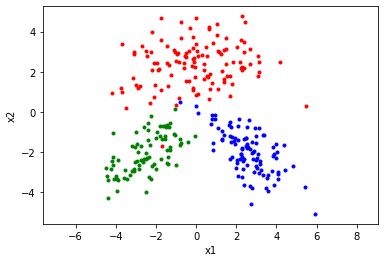

In [4]:
plt.plot(points1[:, 0], points1[:, 1], "r.")
plt.plot(points2[:, 0], points2[:, 1], "g.")
plt.plot(points3[:, 0], points3[:, 1], "b.")
plt.axis('equal')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [5]:
# write data to a file
##np.savetxt("hw1_data_set.csv", np.stack((x[:, 0], x[:, 1], y), axis = 1), fmt = "%f,%f,%d")

PARAMETER ESTIMATION

In [6]:
# parameters
K = 3 # class number
N = 300 # number of data
D = 2 # dimension of x

In [7]:
# calculate sample means
sample_means = [np.mean(x[y == (c + 1)], axis=0) for c in range(K)] # takes the same labels (1s then 2s then 3s)
print(sample_means)

[array([-0.06002766,  2.37891762]), array([-2.4831697 , -2.07440706]), array([ 2.56694496, -1.97561106])]


In [8]:
# calculate sample covariances
sample_covariances = [np.matmul((x[y == (c + 1)] - sample_means[c]).T, (x[y == (c + 1)] - sample_means[c]))/np.count_nonzero(y == (c + 1)) for c in range(K)]
                    # the first term is transposed here since numpy.matrix returns 1xD matrix when applied to the first one but it should be Dx1
print(sample_covariances)

[array([[3.50095118, 0.31087727],
       [0.31087727, 1.21501353]]), array([[1.19789275, 0.64059317],
       [0.64059317, 0.95264859]]), array([[ 1.25199541, -0.79696981],
       [-0.79696981,  1.17191479]])]


In [9]:
# calculate prior probabilities
class_priors = [np.mean(y == (c + 1)) for c in range(K)]
print(class_priors)

[0.4, 0.26666666666666666, 0.3333333333333333]


In [10]:
# score value calculations
Wc = [-0.5 * linalg.cho_solve(linalg.cho_factor(sample_covariances[c]), np.eye(2)) for c in range (K)] 
wc = [np.matmul(linalg.cho_solve(linalg.cho_factor(sample_covariances[c]), np.eye(2)), sample_means[c]) for c in range (K)]
wc0 = [-1/2 * np.matmul(np.matmul(sample_means[c], linalg.cho_solve(linalg.cho_factor(sample_covariances[c]), np.eye(2))), sample_means[c].T) 
       - D/2 * np.log(2 * np.pi)
       - 1/2 * np.log(linalg.det(sample_covariances[c]))
       + np.log(class_priors[c]) for c in range(K)]

In [11]:
# calculate score values
score_values = []
for i in range(N):
    score_values.append(np.stack([np.matmul(np.matmul(x[i], Wc[c]), x[i].T) + np.matmul(wc[c].T, x[i].T) + wc0[c]
                         for c in range(K)]))

In [12]:
# confusion matrix representation
y_pred = np.argmax(score_values, axis=1) + 1
confusion_matrix = pd.crosstab(np.array(y_pred), y, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix)

y_truth    1   2   3
y_pred              
1        119   1   2
2          1  79   0
3          0   0  98


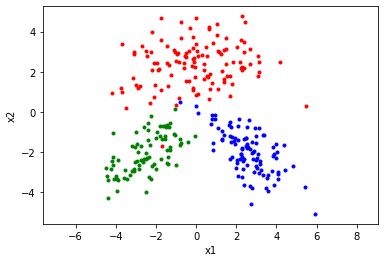

In [13]:
plt.plot(points1[:, 0], points1[:, 1], "r.")
plt.plot(points2[:, 0], points2[:, 1], "g.")
plt.plot(points3[:, 0], points3[:, 1], "b.")
plt.axis('equal')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

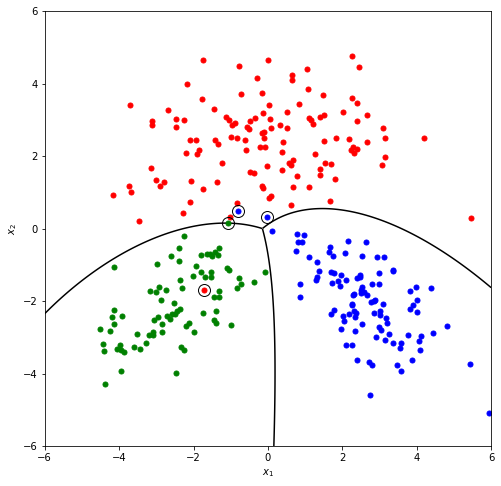

In [14]:
# create grids to plot our data
x1_interval = np.linspace(-6, +6, 1201)
x2_interval = np.linspace(-6, +6, 1201)
xx, yy = np.meshgrid(x1_interval, x2_interval)
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))


# create decision boundaries
for c in range(K):
    discriminant_values[:,:,c] =Wc[c][0][0]*xx**2+ Wc[c][1][1]*yy**2+  Wc[c][1][0]*xx*yy+ wc[c][0] * xx + wc[c][1] * yy + wc0[c]
    
A = discriminant_values[:,:,0]
B = discriminant_values[:,:,1]
C = discriminant_values[:,:,2]
A[(A < B) & (A < C)] = np.nan
B[(B < A) & (B < C)] = np.nan
C[(C < A) & (C < B)] = np.nan
discriminant_values[:,:,0] = A
discriminant_values[:,:,1] = B
discriminant_values[:,:,2] = C
plt.figure(figsize = (8, 8))
plt.plot(x[y == 1, 0], x[y == 1, 1], "r.", markersize = 10)
plt.plot(x[y == 2, 0], x[y == 2, 1], "g.", markersize = 10)
plt.plot(x[y == 3, 0], x[y == 3, 1], "b.", markersize = 10)
plt.plot(x[y_pred != y, 0], x[y_pred != y, 1], "ko", markersize = 12, fillstyle = "none")
#plot lines
plt.contour(xx, yy, discriminant_values[:,:,0] - discriminant_values[:,:,1], levels = 0, colors = "k")
plt.contour(xx, yy, discriminant_values[:,:,0] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.contour(xx, yy, discriminant_values[:,:,1] - discriminant_values[:,:,2], levels = 0, colors = "k")
#color areas
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()